<a href="https://colab.research.google.com/github/ekourkchi/incNET-data/blob/master/CNN_inc_VGG6_regr_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random
from datetime import datetime

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install imgaug

import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib


In [3]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa


ia.seed(1)

seq = iaa.Sequential([

    # iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.1))),
    # iaa.GammaContrast(gamma=(0.97,1.03)),
    # iaa.AdditiveGaussianNoise(0,3),
    iaa.Affine(rotate=(0, 360))
], random_order=True)

In [4]:
data = np.load('/content/drive/My Drive/data_64x64.npz')
images_ = data['images'].astype(np.uint8)
labels_ = data['labels'] 
data.close() 

In [5]:
from sklearn.model_selection import train_test_split

ix, = np.where(labels_[1]>45)

images_c = images_[ix]
labels_c = labels_[1][ix]
pgcIDs_c = labels_[0][ix]

images_train, images_test, labels_train, labels_test, pgcIDs_train,  pgcIDs_test = train_test_split(images_c, labels_c, pgcIDs_c, test_size=0.40)

notUnique = np.isin(pgcIDs_test, pgcIDs_train)
Unique = np.logical_not(notUnique)

images_train = np.concatenate((images_train, images_test[notUnique]))
labels_train  = np.concatenate((labels_train, labels_test[notUnique]))
pgcIDs_train = np.concatenate((pgcIDs_train, pgcIDs_test[notUnique]))

images_test = images_test[Unique]
labels_test = labels_test[Unique]
pgcIDs_test = pgcIDs_test[Unique]


In [6]:
import copy 
t1 = datetime.now()

images_train_aug = copy.deepcopy(images_train)
labels_train_aug = copy.deepcopy(labels_train)
pgcIDs_train_aug = copy.deepcopy(pgcIDs_train)

images_test_aug = copy.deepcopy(images_test)
labels_test_aug = copy.deepcopy(labels_test)
pgcIDs_test_aug = copy.deepcopy(pgcIDs_test)


for i in range(10):
  
  dataAug = seq(images=images_train)
  images_train_aug = np.concatenate((images_train_aug, dataAug)) 
  labels_train_aug = np.concatenate((labels_train_aug, labels_train)) 
  pgcIDs_train_aug = np.concatenate((pgcIDs_train_aug, pgcIDs_train)) 

  dataAug = seq(images=images_test)
  images_test_aug = np.concatenate((images_test_aug, dataAug)) 
  labels_test_aug = np.concatenate((labels_test_aug, labels_test)) 
  pgcIDs_test_aug = np.concatenate((pgcIDs_test_aug, pgcIDs_test)) 


  t2 =  datetime.now()
  print("Execution time: ", i, t2-t1)

Execution time:  0 0:00:08.083345
Execution time:  1 0:00:16.221442
Execution time:  2 0:00:24.699337
Execution time:  3 0:00:32.517848
Execution time:  4 0:00:40.741977
Execution time:  5 0:00:50.237250
Execution time:  6 0:00:59.970977
Execution time:  7 0:01:08.286440
Execution time:  8 0:01:16.980061
Execution time:  9 0:01:25.462655


In [7]:
print(images_train_aug.shape)
print(images_test_aug.shape)

(472956, 64, 64, 3)
(12892, 64, 64, 3)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np
def vgg6(input_shape=(64, 64, 3)):


    model = tf.keras.models.Sequential(name='VGG6')

    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    ## Fully connected layers
    model.add(tf.keras.layers.Flatten())

    # model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    # model.add(tf.keras.layers.Dropout(0.25))
    
    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_2'))
    # model.add(tf.keras.layers.Dropout(0.25))
    
    # model.add(tf.keras.layers.Dense(64, activation='relu', name='fc_3'))
    model.add(tf.keras.layers.Dense(32, activation='relu', name='fc_4'))

    model.add(tf.keras.layers.Dense(8, activation='relu', name='fc_5'))
    # output layer
    model.add(tf.keras.layers.Dense(1, name='fc_out1'))
    model.add(tf.keras.layers.Dense(1, name='fc_out2'))

    return model

In [9]:
import keras.backend as K

def custom_loss(y_true, y_pred):

    yt = K.cast(y_true, dtype='float64')
    yp = K.cast(y_pred, dtype='float64')

    # mask = K.less(y_true, 70) 

    loss = K.square(yt - yp) / K.abs(91.-yt)

    loss = K.mean(loss, -1)  

    # mse = K.sqrt(loss)
    
    # return 0.25 * mask * mse + mse

    return  K.sqrt(loss)




vgg_model = vgg6()
vgg_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae'])
n_epochs=20
vgg_model.summary()
vgg_model_history = vgg_model.fit(images_train_aug, labels_train_aug, 
                                  epochs=n_epochs, batch_size=1024, 
                                  validation_data=(images_test_aug, labels_test_aug),
                                  verbose=1, shuffle=True)


Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 62, 62, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 26, 26, 32)        9248      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 26, 26, 32)        128    

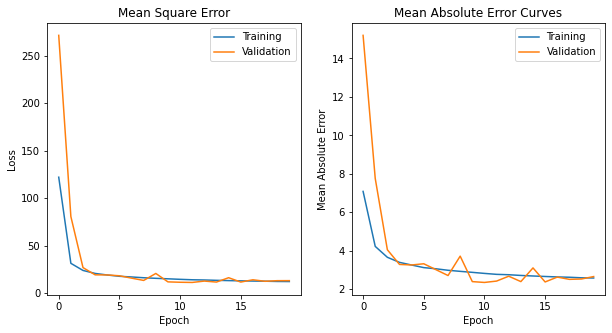

In [10]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation')
    ax[0].set_title('Mean Square Error')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation')
    ax[1].set_title('Mean Absolute Error Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Absolute Error')
    
# plot the training history
# for key in vgg_model.history.history:
#   print key

plot_model_history(vgg_model.history)
  

In [13]:
inc_p = vgg_model.predict(images_test_aug)
inc_m = labels_test_aug


N = images_test_aug.shape[0]
inc_p = inc_p.reshape(N)

Raw RMS:  3.6449019726371903
Adjusted RMS:  3.5975032727352185


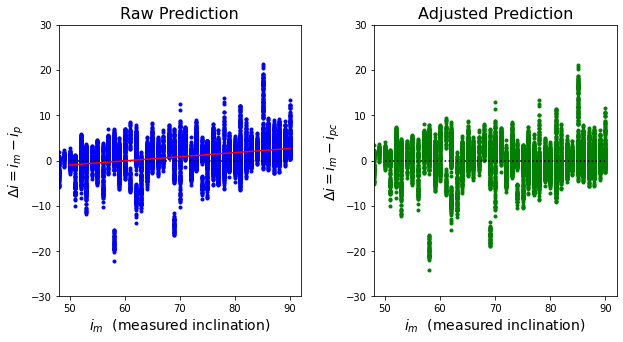

In [16]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p

m, b = np.polyfit(inc_m, d, 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc_m, d, 'b.')
ax[0].plot([50,90],[0,0], 'k:')
ax[0].plot(x, y, 'r-')
ax[0].set_xlim(48,92)
ax[0].set_ylim(-30 ,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print("Raw RMS: ", np.sqrt(np.mean((d)**2)))


d_ = inc_m-(inc_p+b)/(1.-m)
ax[1].plot(inc_m, d_, 'g.')
ax[1].plot([50,90],[0,0], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(-30,30)

print("Adjusted RMS: ", np.sqrt(np.mean((d_)**2)))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)

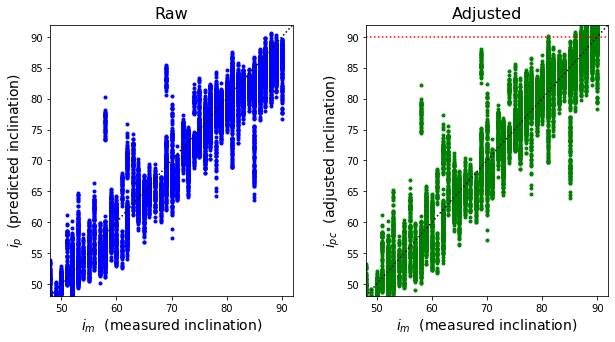

In [17]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

ax[0].plot(inc_m, inc_p, 'b.')
ax[0].plot([48,92],[48,92], 'k:')
ax[0].set_xlim(48,92)
ax[0].set_ylim(48,92)
ax[0].set_title('Raw', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

ax[1].plot(inc_m, (inc_p+b)/(1.-m), 'g.')
ax[1].plot([48,92],[48,92], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(48,92)
ax[1].plot([48,92],[90,90], 'r:')
ax[1].set_title('Adjusted', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$i_{pc}$'+'  (adjusted inclination)', fontsize=14)

plt.subplots_adjust( wspace=0.3)